<a href="https://colab.research.google.com/github/SephoraRuppert/Cosmology212/blob/main/FinalProject_Cosmology_Alkattan%2CRuppert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the following code

This notebook contains the code we (Hashim and Sephora) used to run our MCMC and produce the images and plots included in our report "Constraining lens parameters using MCMC analysis andLentronomymodeling". It is split in two almost identical main sections. "Run 1: No Noise" unsurprisingly genenerates the entire project for no noise in the original image. "Run 2: Noise = 0.001 per pixel" does the same for an original image with noise set to 0.001 per pixel. After running "Install and import stuff", the sections can be run independantly from eachother.

**Acknowledgments**
In writing this code, we heavaly relied on sample codes by Simon Birrer (https://github.com/sibirrer/lenstronomy_extensions/blob/master/lenstronomy_extensions/Notebooks/simple_ring.ipynb) and Justin Ellis (https://github.com/jellis18/practical_mcmc). Some sections of our code are eddited snippets taken from the python codes in the above referenced repositories.

# Install and import stuff


In [ ]:
!pip install multiprocess 
!pip install lenstronomy 

!pip install numpy
!pip install astropy 
!pip install scipy>=0.19.1
!pip install matplotlib 
!pip install mpmath
!pip install emcee 
!pip install corner 
!pip install schwimmbad


     |████████████████████████████████| 450kB 16.3MB/s 
  Created wheel for lenstronomy: filename=lenstronomy-1.6.0-cp36-none-any.whl size=630017 sha256=026b6dbc2fe14dca7baec61e3946e6ff1f350cd72eec8094576e2b998d29f2f5
  Stored in directory: /root/.cache/pip/wheels/f2/38/1c/a68e396195dcf23555cd4558d8f38a1287ab8466dcf71973b3
Successfully built lenstronomy
     |████████████████████████████████| 51kB 7.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for schwimmbad: filename=schwimmbad-0.3.1-cp36-none-any.whl size=13911 sha256=1a562bb6ed65e4c02e350474d5db6dfad8eda3a3b226ce933d49fa764210fa8f
  Stored in directory: /root/.cache/pip/wheels/0b/83/3d/a1899086a931a10732ed3a6a6b93122d9feb47cabd269d6b1e
Successfully built schwimmbad


In [ ]:
import lenstronomy
import scipy
import scipy.stats
import numpy as np
import seaborn as sn
import os
import time
from corner import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
#Function to combine arrays of a data set
def make_array(image):
    arr=[]
    for subarray in image:
        arr = np.concatenate((arr,subarray))
    return arr
import random

#Run 1: No Noise

## Simulate Data 
**Simulate Data**

In [ ]:
# data specifics
background_rms = .0 #  background noise per pixel
exp_time = 500  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# lensing quantities
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': 0.66, 'center_x': 0.05, 'center_y': 0.01, 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

kwargs_lens = [kwargs_spemd, kwargs_shear]
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list)


# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)



# for this example, we ignore the presence of deflector light
#- kill this
#kwargs_sersic_lens = {'amp': 16, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}


#lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = None
#lens_light_model_class = LightModel(lens_light_model_list)

In [ ]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

#We killed "lens_light_model_class=lens_light_model_class", which is an arg that came right after "source_model_class"
from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class,
                        kwargs_numerics=kwargs_numerics)


# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)
# turn 2d data in a 1d data vector

import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + bkg 

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

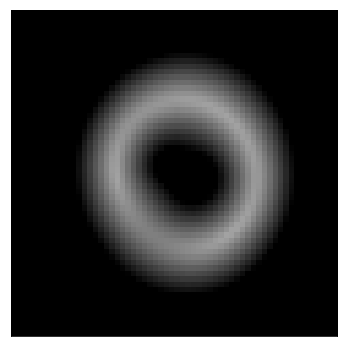

In [ ]:
# display the initial simulated image

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

# make data into one array to be used later
real_array = make_array(image_real)
bkgarr=make_array(bkg)


## MCMC

In [ ]:
def lnprob_func(param):
    # Simulation Choices

    # data specifics
    background_rms = .00 
     #  background noise per pixel
    exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
    numPix = 60  #  cutout pixel size
    deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
    fwhm = 0.05  # full width half max of PSF
    psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

    # lensing quantities
    lens_model_list = ['SIE', 'SHEAR']
    kwargs_spemd = {'theta_E': param[0], 'center_x': param[1], 'center_y': param[2], 'e1': param[3], 'e2': param[4]}  # parameters of the deflector lens model
    kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

    kwargs_lens = [kwargs_spemd, kwargs_shear]
    from lenstronomy.LensModel.lens_model import LensModel
    lens_model_class = LensModel(lens_model_list)


    # Sersic parameters in the initial simulation for the source
    kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
    source_model_list = ['SERSIC_ELLIPSE']
    kwargs_source = [kwargs_sersic]


    from lenstronomy.LightModel.light_model import LightModel
    source_model_class = LightModel(source_model_list)


    # generate the coordinate grid and image properties (we only read out the relevant lines we need)
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


    kwargs_data = {'background_rms': background_rms,  # rms of background noise
                   'exposure_time': exp_time,  # exposure time (or a map per pixel)
                   'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                   'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                   'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                   'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
                  }

    data_class = ImageData(**kwargs_data)
    # generate the psf variables
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

    # if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
    #kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

#We remove the "lens light model arg from here(which came right after source model class arg"
    from lenstronomy.ImSim.image_model import ImageModel
    imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                            source_model_class=source_model_class,
                            kwargs_numerics=kwargs_numerics)

    # generate image
    image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)
    # turn 2d data in a 1d data vector

    import lenstronomy.Util.image_util as image_util
    poisson = image_util.add_poisson(image_model, exp_time=exp_time)
    bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
    image_test = image_model + bkg

    data_class.update_data(image_test)
    kwargs_data['image_data'] = image_test
    
    
    ### Find Chi Squared        
    test_array = make_array(image_test)

    # chisquare(f_obs, f_exp=None)
    x=scipy.stats.chisquare(test_array, f_exp=real_array)

    log_L = -x[0]/2
    return log_L 



In [ ]:
def mh_sampler(x0, lnprob_fn, prop_fn, prop_fn_kwargs={}, iterations=100000):
    
    # number of dimensions
    ndim = len(x0)
    
    # initialize chain, acceptance rate and lnprob
    chain = np.zeros((iterations, ndim))
    lnprob = np.zeros(iterations)
    accept_rate = np.zeros(iterations)
    
    # first samples
    chain[0] = x0
    lnprob0 = lnprob_fn(x0)
    lnprob[0] = lnprob0
    
    # start loop
    naccept = 0
    for ii in range(1, iterations):
        
        # propose
        x_star, factor = prop_fn(x0, **prop_fn_kwargs)
        # draw random uniform number
        #put in seed
        u = np.random.uniform(0, 1)
        
        # compute hastings ratio
        lnprob_star = lnprob_fn(x_star)
        H = np.exp(lnprob_star - lnprob0) * factor
        
        # accept/reject step (update acceptance counter)
        if u < H:
            x0 = x_star
            lnprob0 = lnprob_star
            naccept += 1
        
        # update chain
        chain[ii] = x0
        lnprob[ii] = lnprob0
        accept_rate[ii] = naccept / ii
        
    return chain, accept_rate, lnprob






In [ ]:
def gaussian_proposal(x, sigma):
    
    # Draw x_star
    x_star = x + np.random.randn(len(x)) * sigma
    while (x_star[0] < 0):
      #put in seed
      x_star  = x +  np.random.randn(len(x)) * sigma
    
    x_star = x_star 
    # proposal ratio factor is 1 since jump is symmetric
    qxx = 1
    
    return (x_star, qxx)

In [ ]:
def run_mcmc_plots(pstart, sigma, iterations):
   
    x0 = pstart 
    chain, ar, lnprob = mh_sampler(x0, lnprob_func, gaussian_proposal, 
                                   prop_fn_kwargs={'sigma':sigma}, iterations = iterations)

    plt.figure(figsize=(15, 8))

    burn = int(0.1 * chain.shape[0])


    plt.subplot(221)
    plt.plot(lnprob[burn:])
    plt.ylabel('log-posterior', fontsize=15)
    

    plt.subplot(222)
    plt.plot(ar[burn:])
    plt.ylabel('Acceptance Rate', fontsize=15)
    
    plt.suptitle(r'$\sigma = {}$'.format(sigma), fontsize=15, y=1.02)
    plt.tight_layout()
    plt.show()
    print('The best-fit paramters are  ', chain[np.argmin(np.abs(lnprob))], 'with a log-likelihood of', lnprob[np.argmin(np.abs(lnprob))], 'with MCMC over', iterations, 'iterations')
   
   
    par1true = np.ones(iterations)*[.66]
    par2true = np.ones(iterations)*[.05]
    par3true = np.ones(iterations)*[.01]
    par4true = np.ones(iterations)*[.07]
    par5true = np.ones(iterations)*[-0.03]

    paramTrue=[par1true,par2true,par3true,par4true,par5true]
  
    plt.figure(figsize = (15,15))
    plt.suptitle("Trace Plots")
    
    plt.subplot(321)
    plt.plot(chain[burn:,0], label = 'MCMC chain Einstein radius' )
    plt.plot(par1true, label = 'true value')
    plt.legend()
    
    plt.subplot(322)
    plt.plot(chain[burn:,1], label = 'MCMC chain x position of center' )
    plt.plot(par2true, label = 'true value')
    plt.legend()
    
    plt.subplot(323)
    plt.plot(chain[burn:,2], label = 'MCMC chain y position of center' )
    plt.plot(par3true, label = 'true value')
    plt.legend()

    plt.subplot(324)
    plt.plot(chain[burn:,3], label = 'MCMC chain eccentricity in x' )
    plt.plot(par4true, label = 'true value')
    plt.legend()

    plt.subplot(325)
    plt.plot(chain[burn:,4], label = 'MCMC chain eccentricity in y' )
    plt.plot(par5true, label = 'true value')
    plt.legend()

    
    return chain, chain[np.argmin(np.abs(lnprob))], burn


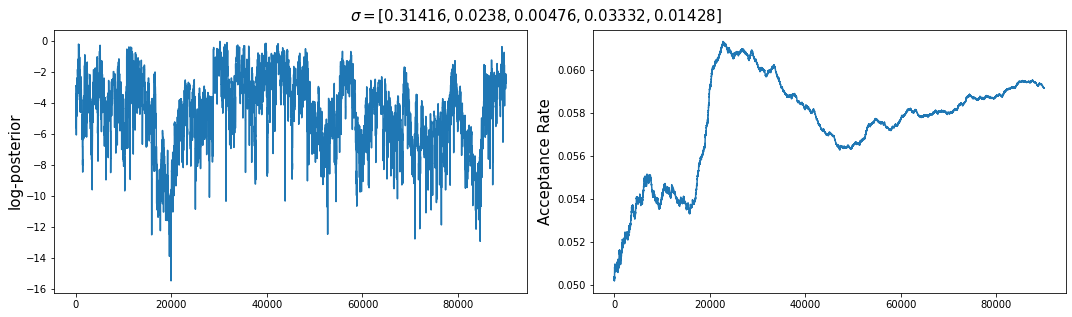

The best-fit paramters are   [ 0.66234548  0.04933535  0.01440821  0.06727909 -0.03082249] with a log-likelihood of -0.03790702661502653 with MCMC over 100000 iterations


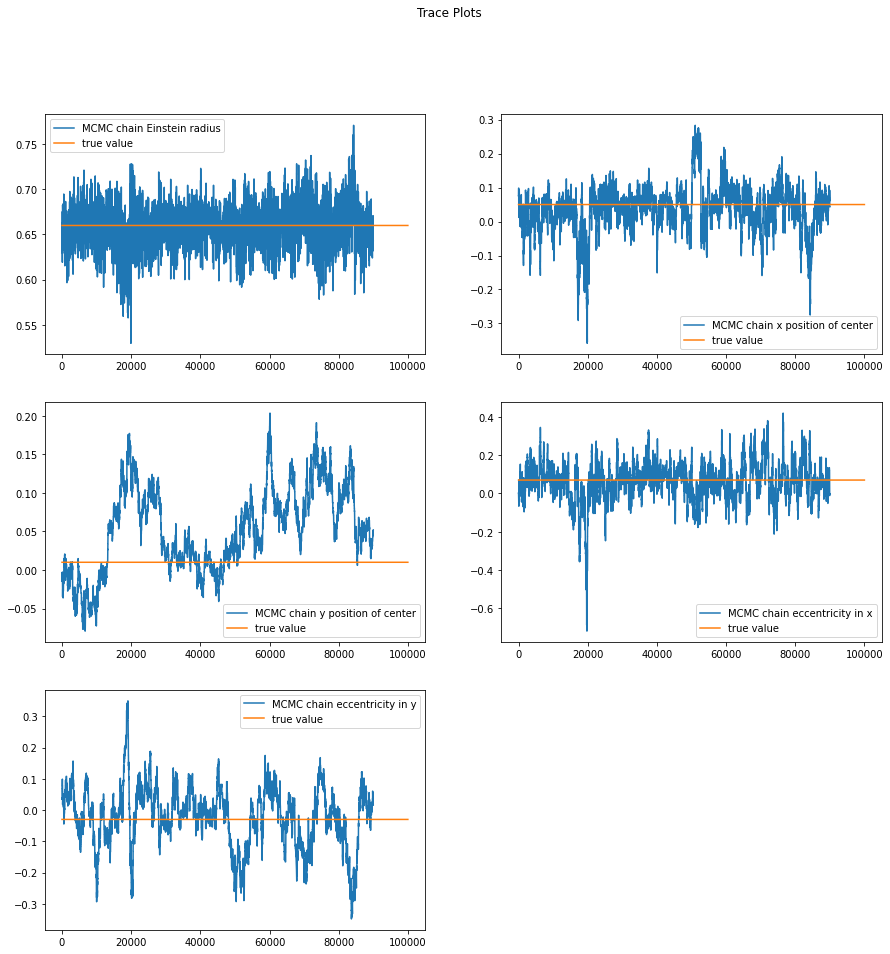

In [ ]:
chain, best_fit, burn=run_mcmc_plots([0.4, 0., 0., 0, 0.05],[0.31416, 0.0238, 0.00476, 0.03332, 0.01428] ,100000)

In [ ]:
par1, par2, par3, par4, par5 = chain[burn:, 0], chain[burn:, 1], chain[burn:, 2],chain[burn:, 3],chain[burn:, 4]

data = np.array([par1,par2, par3, par4, par5])

covMatrix = np.cov(data,bias=True)
print(covMatrix)

[[ 4.59453942e-04 -1.41930377e-04 -3.47918241e-05  7.55275826e-04
  -7.16332767e-04]
 [-1.41930377e-04  4.78503131e-03 -1.16486370e-04  2.44321575e-04
   9.18462063e-04]
 [-3.47918241e-05 -1.16486370e-04  2.99170529e-03 -1.01717930e-03
   2.21872795e-04]
 [ 7.55275826e-04  2.44321575e-04 -1.01717930e-03  1.10913382e-02
  -8.47254046e-04]
 [-7.16332767e-04  9.18462063e-04  2.21872795e-04 -8.47254046e-04
   9.50776581e-03]]


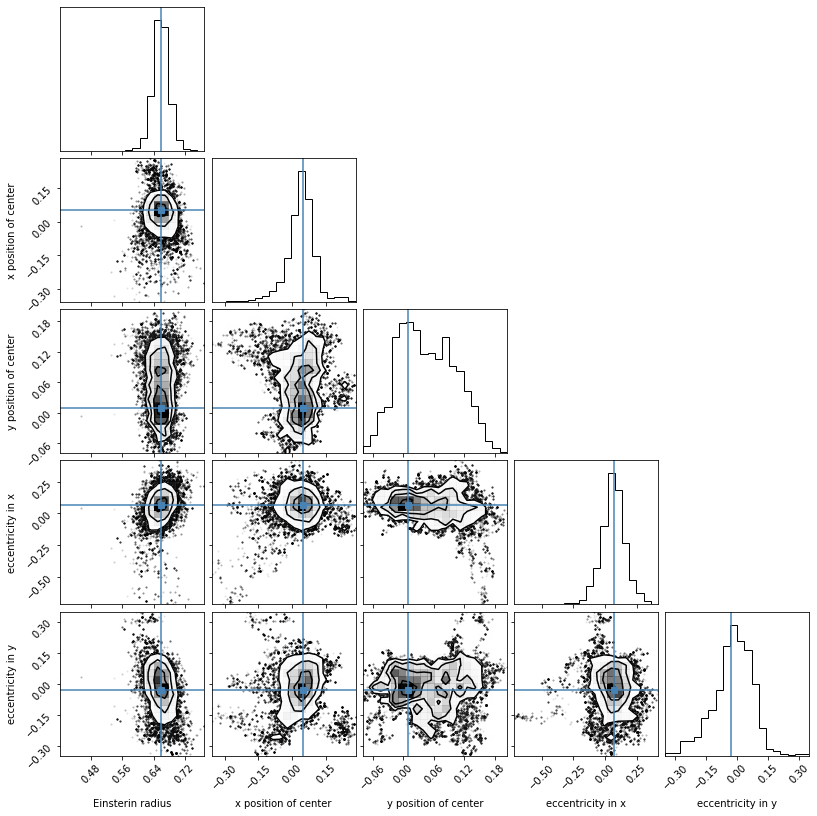

In [ ]:
fig = corner(chain, labels=['Einsterin radius', 'x position of center', 'y position of center', 'eccentricity in x', 'eccentricity in y'], truths=[0.66, 0.05, 0.01, 0.07, -0.03]);

## Constructing best fit Image

In [ ]:
print(best_fit)

[ 0.66234548  0.04933535  0.01440821  0.06727909 -0.03082249]


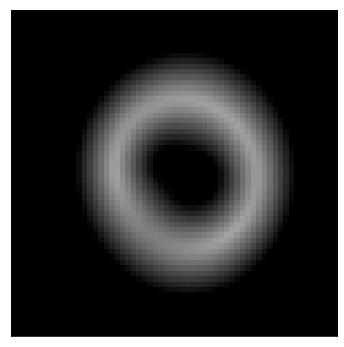

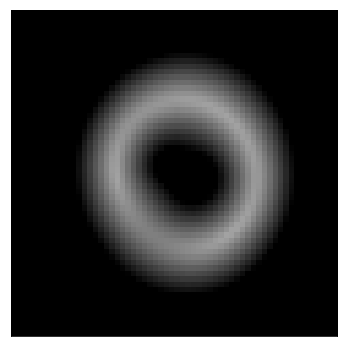

In [ ]:
# data specifics
background_rms = .00 
  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# lensing quantities
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': best_fit[0], 'center_x': best_fit[1], 'center_y': best_fit[2], 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

kwargs_lens = [kwargs_spemd, kwargs_shear]
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list)


# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)



# for this example, we ignore the presence of deflector light
# kwargs_sersic_lens = {'amp': 16, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}


# lens_light_model_list = ['SERSIC_ELLIPSE']
# kwargs_lens_light = [kwargs_sersic_lens]
# lens_light_model_class = LightModel(lens_light_model_list)

# ----------

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
                'exposure_time': exp_time,  # exposure time (or a map per pixel)
                'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

#We remove the "lens light model arg from here(which came right after source model class arg"
from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)
# turn 2d data in a 1d data vector

import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_test = image_model + bkg

data_class.update_data(image_test)
kwargs_data['image_data'] = image_test

# display the initial simulated image

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_test), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

# real image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()


#Run 2: Noise = 0.001 per pixel

## Simulate Data 
**Simulate Data**

In [87]:
# data specifics
background_rms = .0001 #  background noise per pixel
exp_time = 500  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# lensing quantities
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': 0.66, 'center_x': 0.05, 'center_y': 0.01, 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

kwargs_lens = [kwargs_spemd, kwargs_shear]
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list)


# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)



# for this example, we ignore the presence of deflector light
#- kill this
#kwargs_sersic_lens = {'amp': 16, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}


#lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = None
#lens_light_model_class = LightModel(lens_light_model_list)

In [80]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

#We killed "lens_light_model_class=lens_light_model_class", which is an arg that came right after "source_model_class"
from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class,
                        kwargs_numerics=kwargs_numerics)


# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)
# turn 2d data in a 1d data vector

import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + bkg 

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


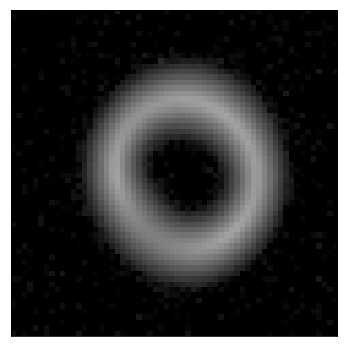

In [81]:
# display the initial simulated image

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

# make data into one array to be used later
real_array = make_array(image_real)
bkgarr=make_array(bkg)


## MCMC

In [ ]:
def lnprob_func(param):
    # Simulation Choices

    # data specifics
    background_rms = .00 
     #  background noise per pixel
    exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
    numPix = 60  #  cutout pixel size
    deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
    fwhm = 0.05  # full width half max of PSF
    psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

    # lensing quantities
    lens_model_list = ['SIE', 'SHEAR']
    kwargs_spemd = {'theta_E': param[0], 'center_x': param[1], 'center_y': param[2], 'e1': param[3], 'e2': param[4]}  # parameters of the deflector lens model
    kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

    kwargs_lens = [kwargs_spemd, kwargs_shear]
    from lenstronomy.LensModel.lens_model import LensModel
    lens_model_class = LensModel(lens_model_list)


    # Sersic parameters in the initial simulation for the source
    kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
    source_model_list = ['SERSIC_ELLIPSE']
    kwargs_source = [kwargs_sersic]


    from lenstronomy.LightModel.light_model import LightModel
    source_model_class = LightModel(source_model_list)


    # generate the coordinate grid and image properties (we only read out the relevant lines we need)
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


    kwargs_data = {'background_rms': background_rms,  # rms of background noise
                   'exposure_time': exp_time,  # exposure time (or a map per pixel)
                   'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                   'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                   'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                   'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
                  }

    data_class = ImageData(**kwargs_data)
    # generate the psf variables
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

    # if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
    #kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

#We remove the "lens light model arg from here(which came right after source model class arg"
    from lenstronomy.ImSim.image_model import ImageModel
    imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                            source_model_class=source_model_class,
                            kwargs_numerics=kwargs_numerics)

    # generate image
    image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)
    # turn 2d data in a 1d data vector

    import lenstronomy.Util.image_util as image_util
    poisson = image_util.add_poisson(image_model, exp_time=exp_time)
    bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
    image_test = image_model + bkg

    data_class.update_data(image_test)
    kwargs_data['image_data'] = image_test
    
    
    ### Find Chi Squared        
    test_array = make_array(image_test)

    # chisquare(f_obs, f_exp=None)
    x=scipy.stats.chisquare(test_array, f_exp=real_array)

    log_L = -x[0]/2
    return log_L 



In [ ]:
def mh_sampler(x0, lnprob_fn, prop_fn, prop_fn_kwargs={}, iterations=100000):
        
    # number of dimensions
    ndim = len(x0)
    
    # initialize chain, acceptance rate and lnprob
    chain = np.zeros((iterations, ndim))
    lnprob = np.zeros(iterations)
    accept_rate = np.zeros(iterations)
    
    # first samples
    chain[0] = x0
    lnprob0 = lnprob_fn(x0)
    lnprob[0] = lnprob0
    
    # start loop
    naccept = 0
    for ii in range(1, iterations):
        
        # propose
        x_star, factor = prop_fn(x0, **prop_fn_kwargs)
        # draw random uniform number
        #put in seed
        u = np.random.uniform(0, 1)
        
        # compute hastings ratio
        lnprob_star = lnprob_fn(x_star)
        H = np.exp(lnprob_star - lnprob0) * factor
        
        # accept/reject step (update acceptance counter)
        if u < H:
            x0 = x_star
            lnprob0 = lnprob_star
            naccept += 1
        
        # update chain
        chain[ii] = x0
        lnprob[ii] = lnprob0
        accept_rate[ii] = naccept / ii
        
    return chain, accept_rate, lnprob






In [ ]:
def gaussian_proposal(x, sigma):
  
    
    # Draw x_star
    x_star = x + np.random.randn(len(x)) * sigma
    while (x_star[0] < 0):
      #put in seed
      x_star  = x +  np.random.randn(len(x)) * sigma
    
    x_star = x_star 
    # proposal ratio factor is 1 since jump is symmetric
    qxx = 1
    
    return (x_star, qxx)

In [109]:
def run_mcmc_plots(pstart, sigma, iterations):
   
    x0 = pstart 
    chain, ar, lnprob = mh_sampler(x0, lnprob_func, gaussian_proposal, 
                                   prop_fn_kwargs={'sigma':sigma}, iterations = iterations)

    plt.figure(figsize=(15, 8))

    burn = int(0.3 * chain.shape[0])

    plt.subplot(221)
    plt.plot(lnprob[burn:])
    plt.ylabel('log-posterior', fontsize=15)
    

    plt.subplot(222)
    plt.plot(ar[burn:])
    plt.ylabel('Acceptance Rate', fontsize=15)
    
    plt.suptitle(r'$\sigma = {}$'.format(sigma), fontsize=15, y=1.02)
    plt.tight_layout()
    plt.show()
    print('The best-fit paramters are  ', chain[np.argmin(np.abs(lnprob))], 'with a log-likelihood of', lnprob[np.argmin(np.abs(lnprob))], 'with MCMC over', iterations, 'iterations')
   
   
   
    par1true = np.ones(iterations)*[.66]
    par2true = np.ones(iterations)*[.05]
    par3true = np.ones(iterations)*[.01]
    par4true = np.ones(iterations)*[.07]
    par5true = np.ones(iterations)*[-0.03]

    paramTrue=[par1true,par2true,par3true,par4true,par5true]
  
    plt.figure(figsize = (15,15))
    plt.suptitle("Trace Plots")
    
    plt.subplot(321)
    plt.plot(chain[burn:,0], label = 'MCMC chain Einstein radius' )
    plt.plot(par1true, label = 'true value')
    plt.legend()
    
    plt.subplot(322)
    plt.plot(chain[burn:,1], label = 'MCMC chain x position of center' )
    plt.plot(par2true, label = 'true value')
    plt.legend()
    
    plt.subplot(323)
    plt.plot(chain[burn:,2], label = 'MCMC chain y position of center' )
    plt.plot(par3true, label = 'true value')
    plt.legend()

    plt.subplot(324)
    plt.plot(chain[burn:,3], label = 'MCMC chain eccentricity in x' )
    plt.plot(par4true, label = 'true value')
    plt.legend()

    plt.subplot(325)
    plt.plot(chain[burn:,4], label = 'MCMC chain eccentricity in y' )
    plt.plot(par5true, label = 'true value')
    plt.legend()

    
    return chain, chain[np.argmin(np.abs(lnprob))], burn


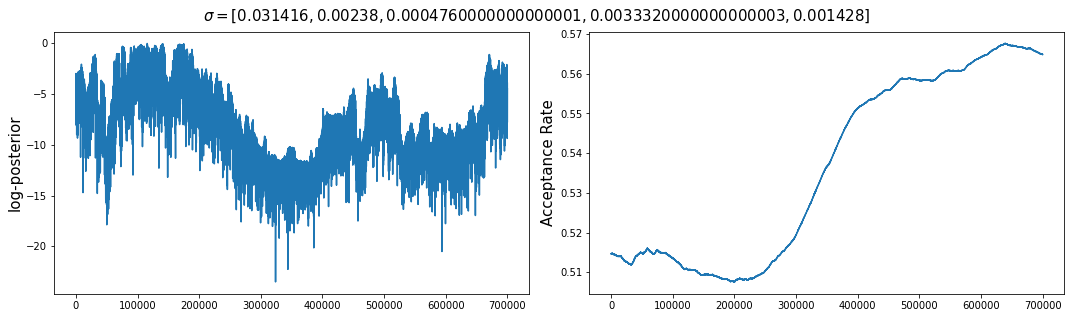

The best-fit paramters are   [ 0.66144542  0.05286556  0.0077464   0.07189806 -0.0377408 ] with a log-likelihood of -0.03451053859110601 with MCMC over 1000000 iterations


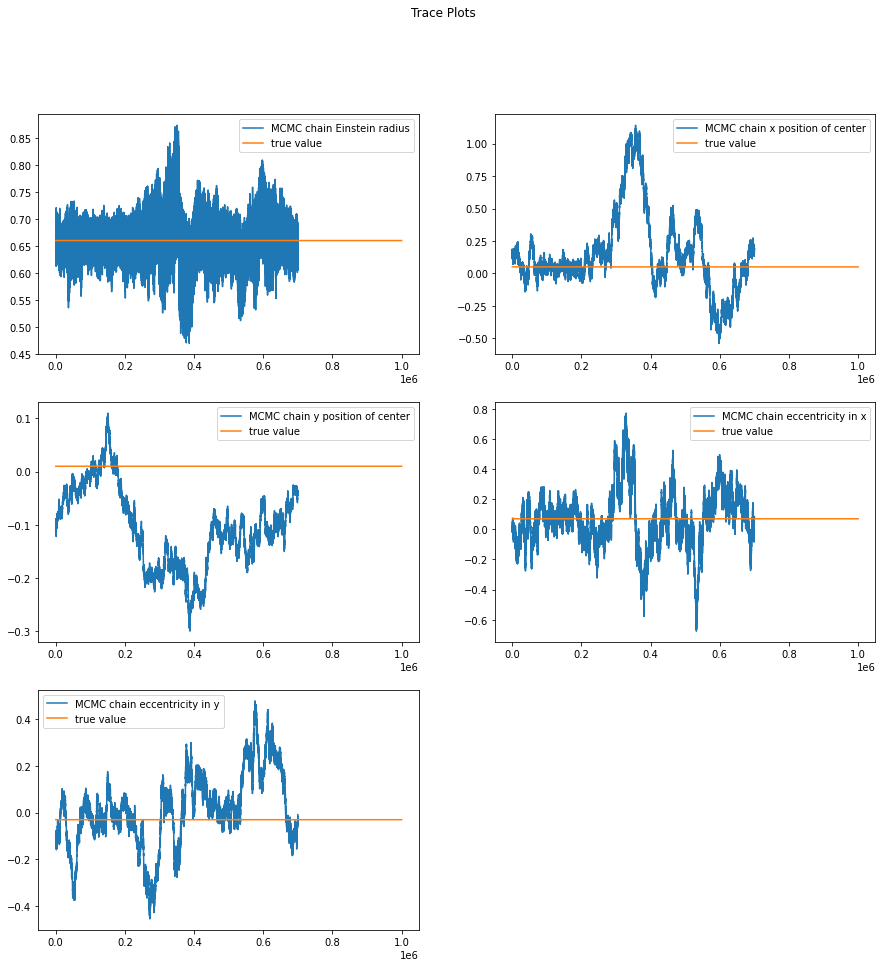

In [110]:
chain1, best_fit1, burn1=run_mcmc_plots([0.4, 0.0, 0.0, 0.0, 0.05],[0.1*0.31416, 0.1*0.0238,0.1*0.00476,0.1* 0.03332,0.1* 0.01428] ,1000000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


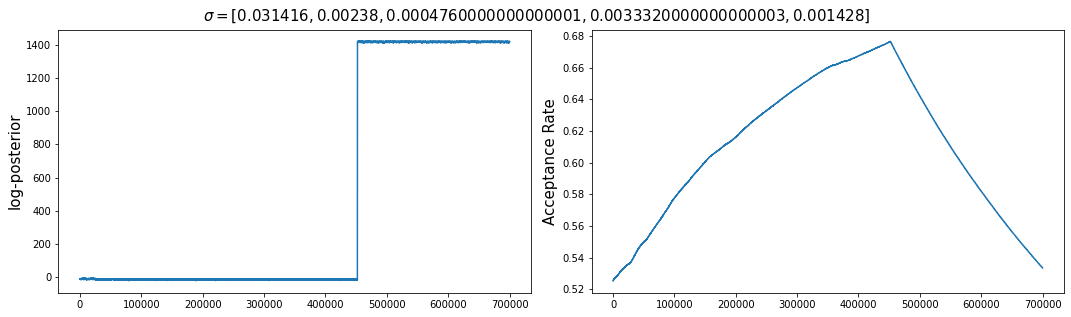

The best-fit paramters are   [ 0.6600174   0.04763214  0.01174267  0.07497353 -0.0281641 ] with a log-likelihood of -0.01751014063746249 with MCMC over 1000000 iterations


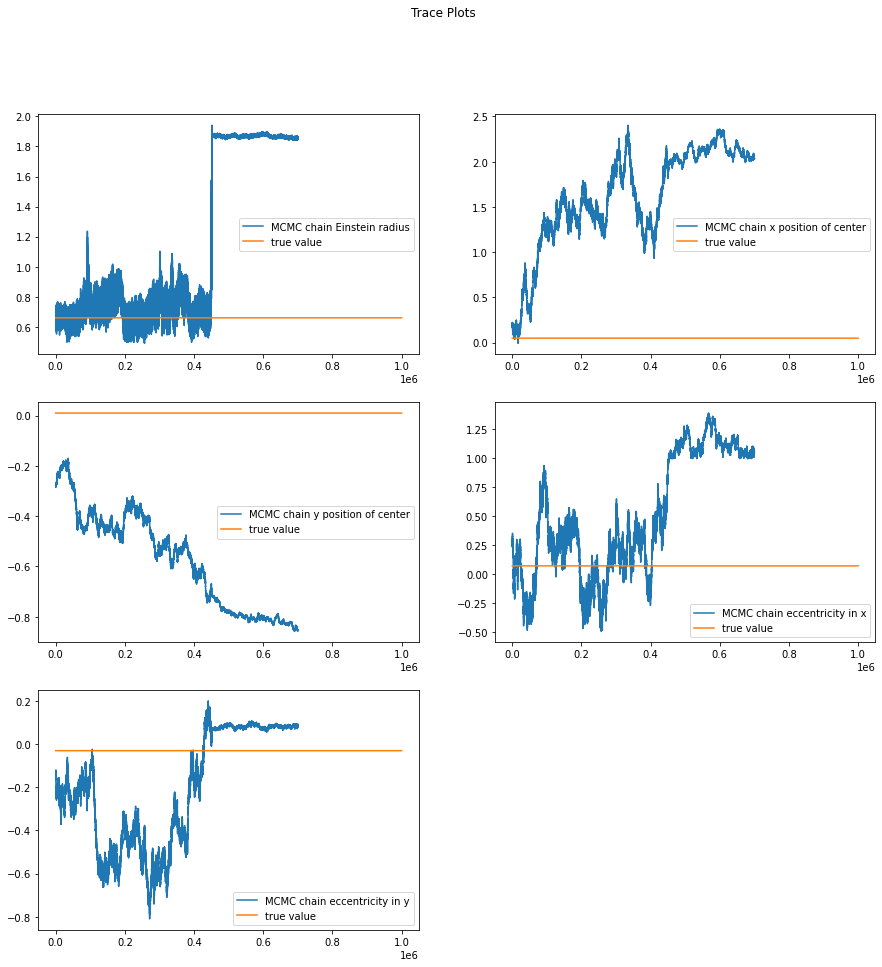

In [111]:
chain2, best_fit2, burn2=run_mcmc_plots([0.4, 0.03, 0.01, 0.03, -0.01],[0.1*0.31416, 0.1*0.0238,0.1*0.00476,0.1* 0.03332,0.1* 0.01428] ,1000000)

In [118]:
par1, par2, par3, par4, par5 = chain1[burn1:, 0], chain1[burn1:, 1], chain1[burn1:, 2],chain1[burn1:, 3],chain1[burn1:, 4]

data = np.array([par1,par2, par3, par4, par5])

covMatrix = np.cov(data,bias=True)
print(covMatrix)

[[ 0.00136062 -0.0007959  -0.00013472  0.00387191 -0.00063613]
 [-0.0007959   0.09584319 -0.00895213 -0.00331386 -0.01636744]
 [-0.00013472 -0.00895213  0.00575997  0.00139018 -0.00086357]
 [ 0.00387191 -0.00331386  0.00139018  0.03846469  0.00316926]
 [-0.00063613 -0.01636744 -0.00086357  0.00316926  0.02629609]]


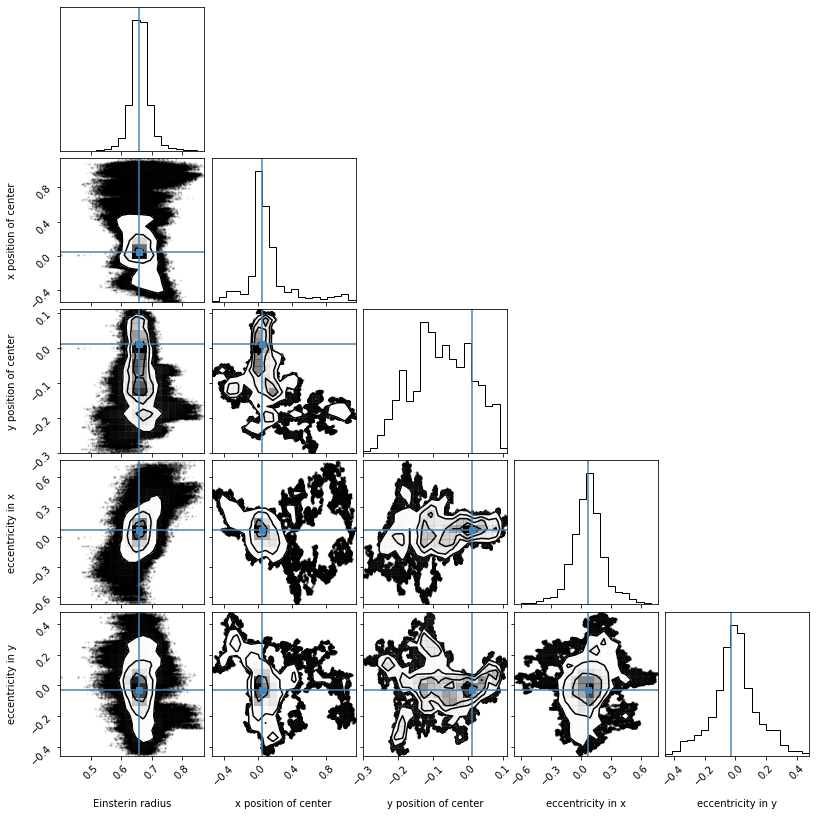

In [119]:
fig = corner(chain1, labels=['Einsterin radius', 'x position of center', 'y position of center', 'eccentricity in x', 'eccentricity in y'], truths=[0.66, 0.05, 0.01, 0.07, -0.03]);

## Constructing best fit Image

In [144]:
best_fit=best_fit1
print(best_fit)

[ 0.66144542  0.05286556  0.0077464   0.07189806 -0.0377408 ]


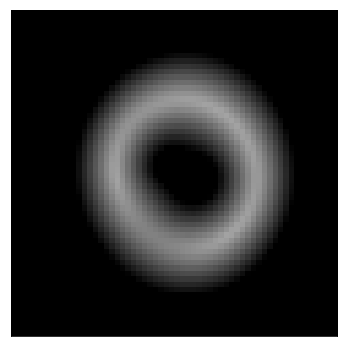

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in log10


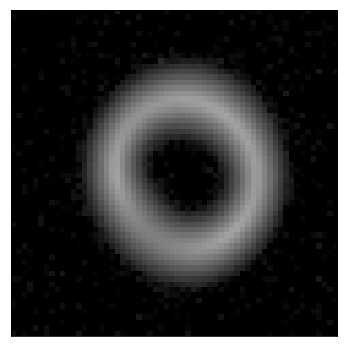

In [145]:
# data specifics
background_rms = .00 
  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# lensing quantities
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': best_fit[0], 'center_x': best_fit[1], 'center_y': best_fit[2], 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

kwargs_lens = [kwargs_spemd, kwargs_shear]
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list)


# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)


# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
                'exposure_time': exp_time,  # exposure time (or a map per pixel)
                'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

#We remove the "lens light model arg from here(which came right after source model class arg"
from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)
# turn 2d data in a 1d data vector

import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_test = image_model + bkg

data_class.update_data(image_test)
kwargs_data['image_data'] = image_test

# display the initial simulated image

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_test), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

# real image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()
